In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from utils.utilities import bootstrap_all_distance_metrics
import os
from collections import defaultdict
n = 5

rf_with_dist_all_distance_metrics_without_pca.pkl
1
with_distance True
Predicted vs labels Random Forrest with dist all distance metrics without pca


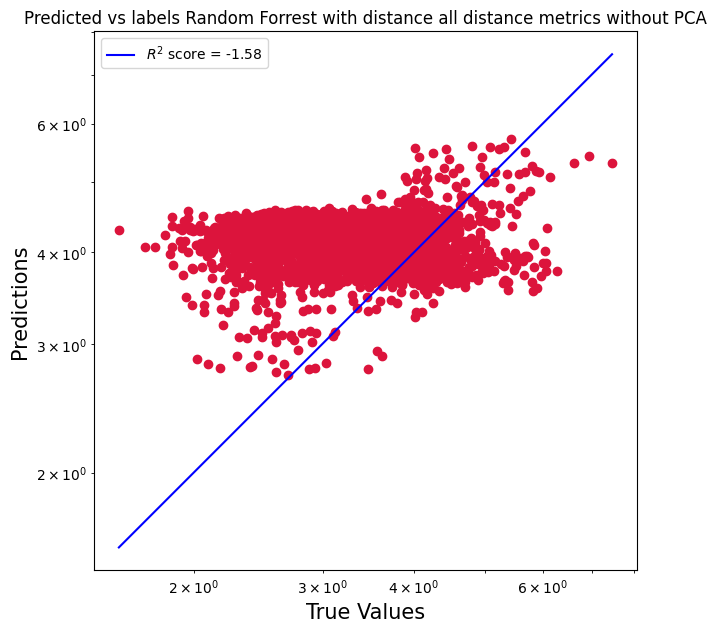

rf_with_dist_all_distance_metrics_with_pca.pkl
1
with_distance True
Predicted vs labels Random Forrest with dist all distance metrics with pca


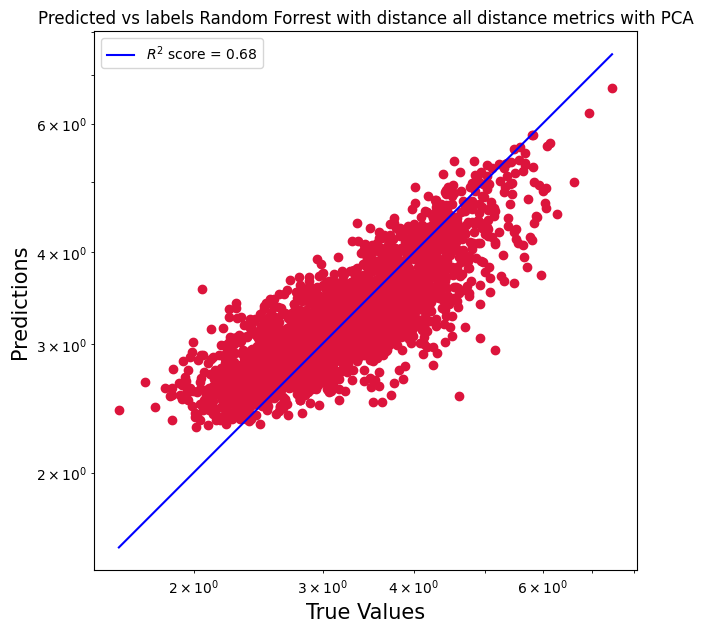

rf_with_dist.pkl
2
Predicted vs labels Random Forrest with dist


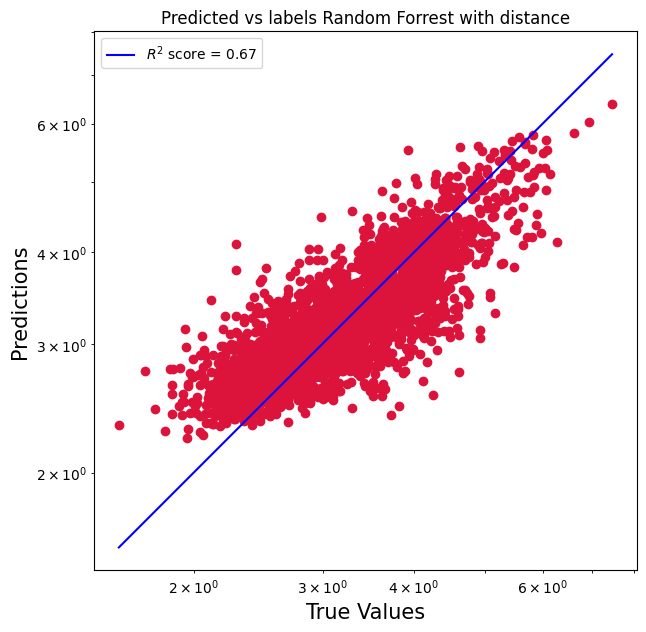

lasso_with_dist_all_distance_metrics_with_pca.pkl
1
with_distance True
Predicted vs labels LASSO with dist all distance metrics with pca


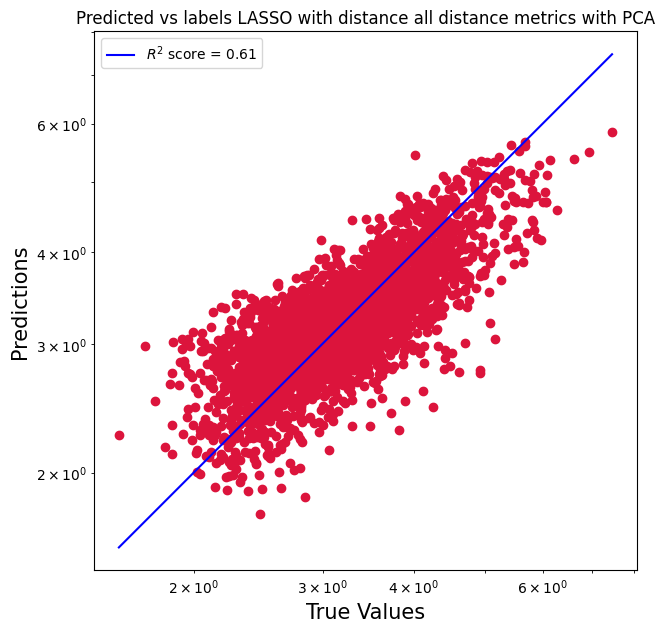

lasso_without_dist_all_distance_metrics_without_pca.pkl
1
with_distance False
Predicted vs labels LASSO without dist all distance metrics without pca


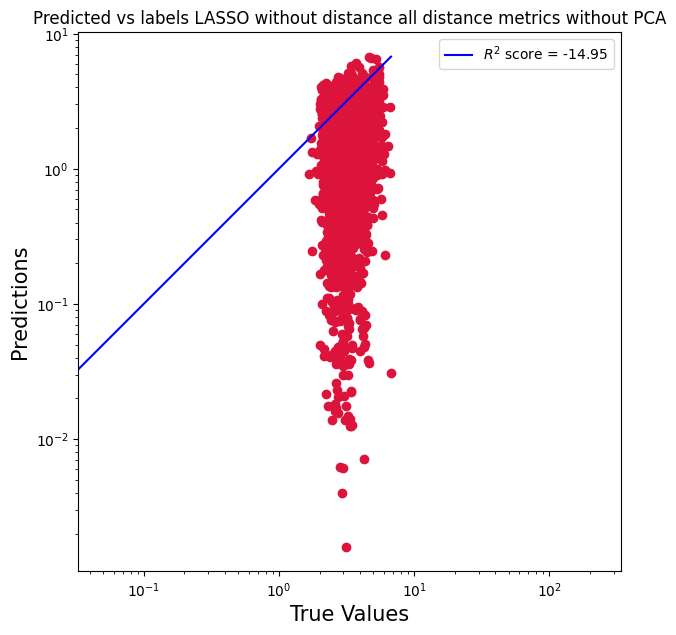

lasso_without_dist_all_distance_metrics_with_pca.pkl
1
with_distance False
Predicted vs labels LASSO without dist all distance metrics with pca


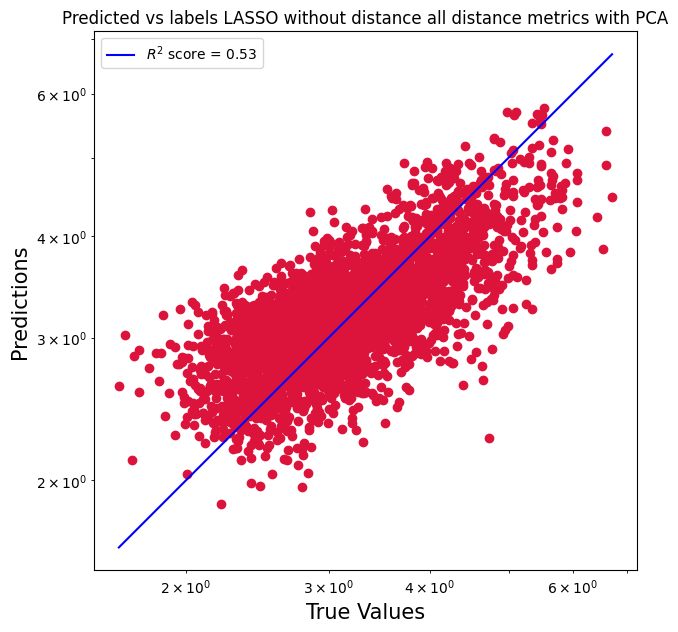

rf_without_dist_all_distance_metrics_with_pca.pkl
1
with_distance False
Predicted vs labels Random Forrest without dist all distance metrics with pca


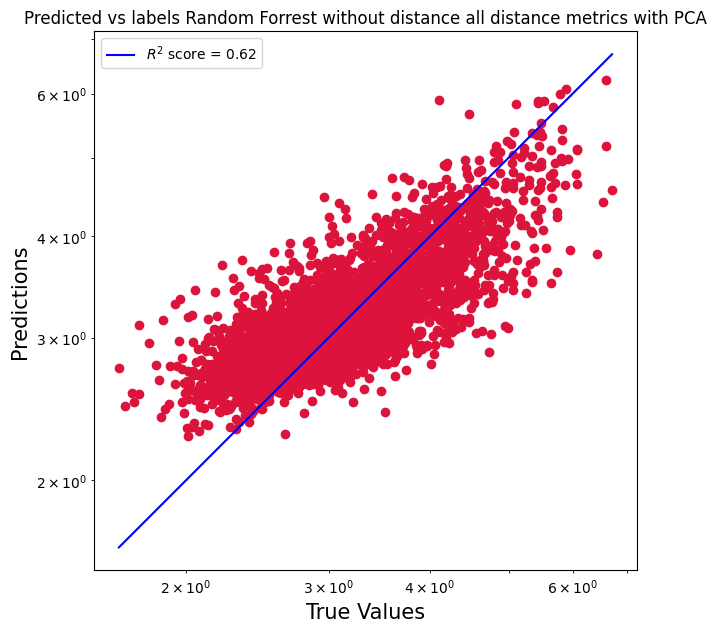

lasso_with_dist_all_distance_metrics_without_pca.pkl
1
with_distance True
Predicted vs labels LASSO with dist all distance metrics without pca


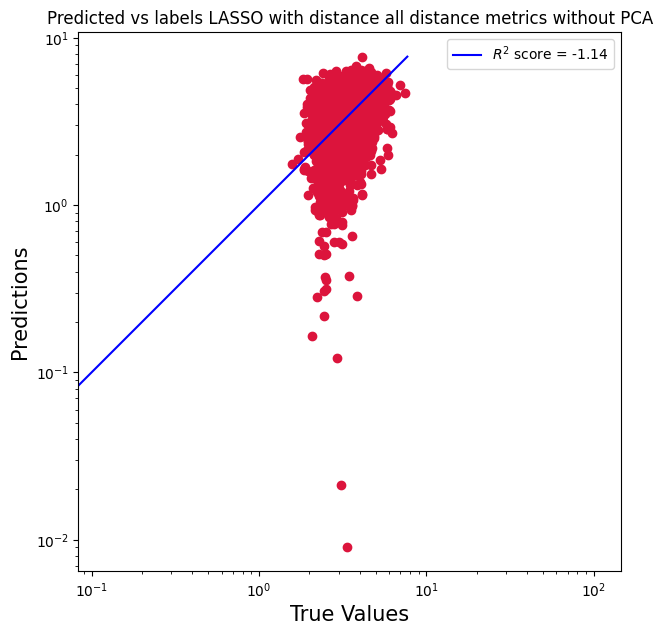

lasso_without_dist.pkl
3
Predicted vs labels LASSO without dist


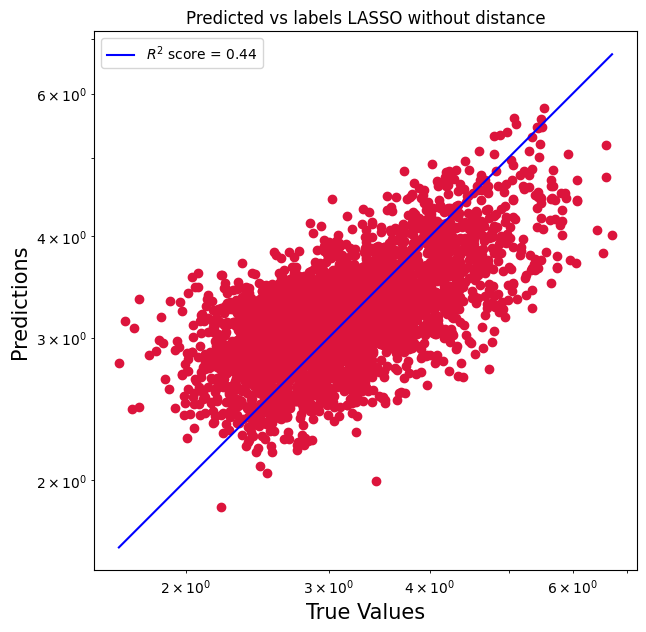

lasso_with_dist.pkl
2
Predicted vs labels LASSO with dist


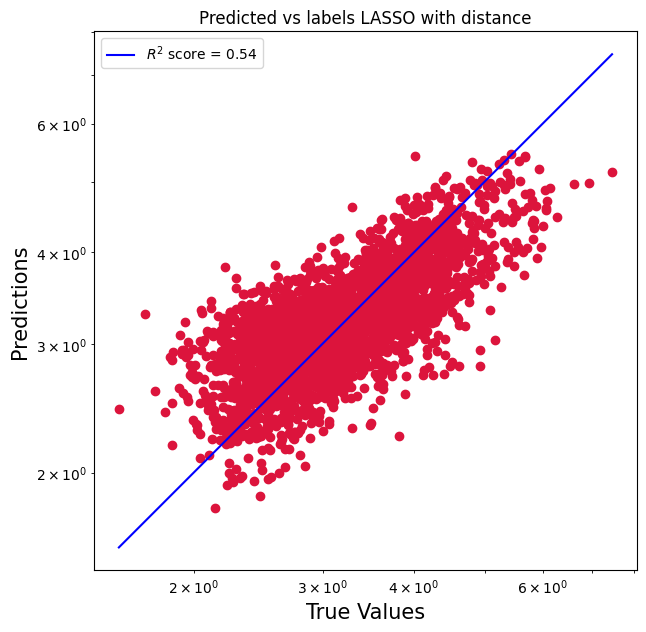

rf_without_dist_all_distance_metrics_without_pca.pkl
1
with_distance False
Predicted vs labels Random Forrest without dist all distance metrics without pca


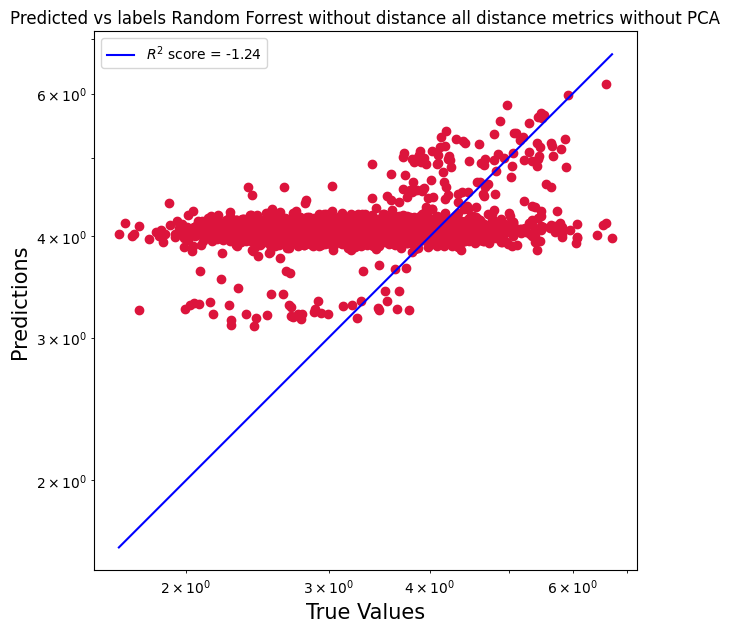

rf_without_dist.pkl
3


In [1]:
from src.drivers.plots.plot_all_pred_vs_label import run
run()